In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error
import xgboost as xgb
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [45]:
data = pd.read_csv('../data/regional_multivariate_data.csv')


enc = pd.read_csv('../data/regional_datasets/multivariate/enc_data_multi.csv').drop(columns = 'Unnamed: 0')
esc = pd.read_csv('../data/regional_datasets/multivariate/esc_data_multi.csv').drop(columns = 'Unnamed: 0')
midatl = pd.read_csv('../data/regional_datasets/multivariate/mid_atlantic_data_multi.csv').drop(columns = 'Unnamed: 0')
mount = pd.read_csv('../data/regional_datasets/multivariate/mountain_data_multi.csv').drop(columns = 'Unnamed: 0')
ne = pd.read_csv('../data/regional_datasets/univariate/new_england_data_univ.csv').drop(columns = 'Unnamed: 0')
pac = pd.read_csv('../data/regional_datasets/univariate/pacific_data_univ.csv').drop(columns = 'Unnamed: 0')
satl = pd.read_csv('../data/regional_datasets/univariate/south_atlantic_data_univ.csv').drop(columns = 'Unnamed: 0')
wnc = pd.read_csv('../data/regional_datasets/univariate/wnc_data_univ.csv').drop(columns = 'Unnamed: 0')
wsc = pd.read_csv('../data/regional_datasets/univariate/wsc_data_univ.csv').drop(columns = 'Unnamed: 0')

def prepare_and_split_data(data, test_size = 0.15):

    # copy data and ensure sorted by date
    data = data.copy() 
    data['date'] = pd.to_datetime(data['date'])
    data = data.sort_values(by = 'date')

    # This removes the first n observations so that there are no NaNs in the lag columns
    last_nan = data[data.isna().any(axis = 1)].tail(1).index.item()
    data = data[(last_nan + 1):]
    data.set_index('date', inplace=True)



    X = data.drop(['new_confirmed', 'region'], axis=1)
    y = data['new_confirmed']
    #dates = data['date']

    # Split the dataset
    size = round(data.shape[0]*0.15)
    train = data.iloc[:-size]
    test = data.iloc[-size:]    

    X_train = train.drop(columns=['new_confirmed', 'region'])
    y_train = train['new_confirmed']

    X_test = test.drop(columns=['new_confirmed', 'region'])
    y_test = test['new_confirmed']

    return X_train, X_test, y_train, y_test

# ENC

In [3]:
Xtrain, Xtest, ytrain, ytest = prepare_and_split_data(enc)

/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8

Text(0.5, 0, 'Number of trees')

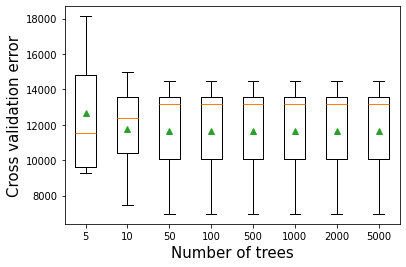

In [4]:
def n_trees():
    models = {}
    n_trees = [5, 10, 50, 100, 500, 1000, 2000, 5000]
    for n in n_trees:
        models[str(n)] = xgb.XGBRegressor(n_estimators=n,random_state=1)
    return models

def evaluate_model(model, X, y):
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = n_trees()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, Xtrain, ytrain)
    results.append(scores)
    names.append(name)
    # print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Number of trees',fontsize=15)

Text(0.5, 0, 'Depth of each tree')

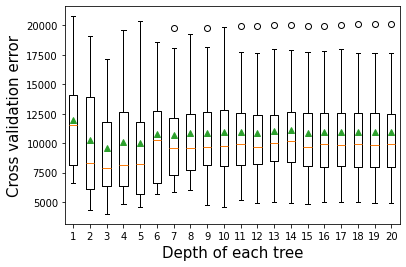

In [5]:
def max_depth():
    models = {}
    for i in range(1,21):
        models[str(i)] = xgb.XGBRegressor(random_state=1,max_depth=i)
    return models

def evaluate_model(model, X, y):
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = max_depth()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, Xtrain, ytrain)
    results.append(scores)
    names.append(name)
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Depth of each tree',fontsize=15)

Text(0.5, 0, 'Learning rate')

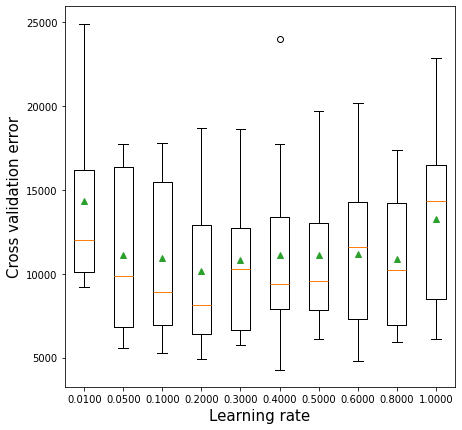

In [6]:
def learning_rate():
    models = {}
    for i in [0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.8,1.0]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(learning_rate=i,random_state=1)
    return models

def evaluate_model(model, X, y):
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = learning_rate()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, Xtrain, ytrain)
    results.append(scores)
    names.append(name)
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Learning rate',fontsize=15)

Text(0.5, 0, 'reg_lambda')

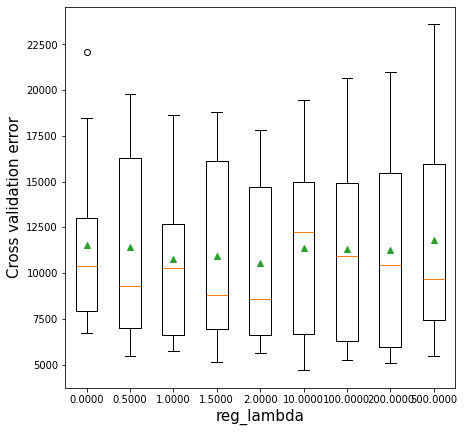

In [7]:
def reg_lambda():
    models = dict()
    for i in [0,0.5,1.0,1.5,2,10,100, 200, 500]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(reg_lambda=i,random_state=1)
    return models

def evaluate_model(model, X, y):
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = reg_lambda()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, Xtrain, ytrain)
    results.append(scores)
    names.append(name)
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('reg_lambda',fontsize=15)

Text(0.5, 0, 'gamma')

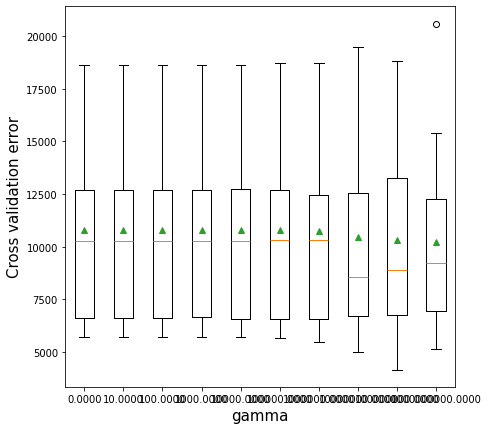

In [8]:
def gamma():
    models = dict()
    for i in [0,10,1e2,1e3,1e4,1e5,1e6,1e7,1e8,1e9]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(gamma=i,random_state=1)
    return models

def evaluate_model(model, X, y):
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = gamma()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, Xtrain, ytrain)
    results.append(scores)
    names.append(name)
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('gamma',fontsize=15)

Text(0.5, 0, 'gamma')

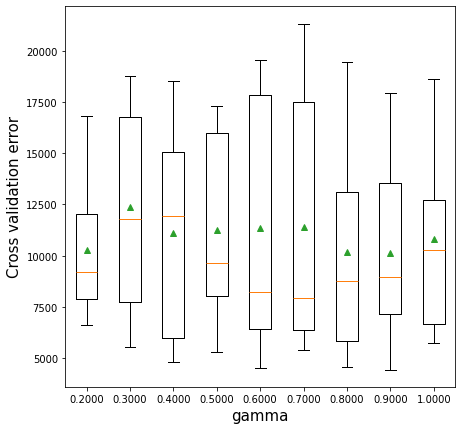

In [9]:
def subsample():
    models = dict()
    for i in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(subsample=i,random_state=1)
    return models

models = subsample()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, Xtrain, ytrain)
    results.append(scores)
    names.append(name)
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('gamma',fontsize=15)

In [10]:
def xgb_search(xtrain, xtest, ytrain, ytest, params):
    grid_search = GridSearchCV(xgb.XGBRegressor(), params, cv=3)

    grid_search.fit(xtrain, ytrain)

    best_params = grid_search.best_params_

    print("Optimal parameter values =", best_params)
    print("Optimal cross validation R-squared = ", grid_search.best_score_)

    xgb_model = XGBRegressor(**best_params)

    xgb_model.fit(Xtrain, ytrain)

    predictions = xgb_model.predict(xtest)
    mae = mean_absolute_error(ytest, predictions)
    rmse = np.sqrt(mean_squared_error(ytest, predictions))
    mse = mean_squared_error(ytest, predictions)
    mase = mean_absolute_scaled_error(ytest, predictions, y_train =ytrain)
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print(f"MSE: {mse}")
    print(f"MASE: {mase}")

    # date_idx = len(dates) - len(predictions)
    # test_dates = dates[date_idx:]
    # y_test_series = pd.Series(ytest.values, index=test_dates)  

    # plot = pd.DataFrame({
    #     'Actual': y_test_series,
    #     'Predicted': predictions
    # }, index=test_dates) 

    plt.figure(figsize=(20, 12))  
    # plot['Actual'].plot(label='Actual', color='blue')
    # plot['Predicted'].plot(label='Predicted', color='orange')
    # plt.title('Actual vs Predicted')
    # plt.xlabel('Date')
    # plt.ylabel('New Confirmed Cases')
    # plt.legend()
    # plt.xticks(rotation=45)  
    # plt.tight_layout()  
    # plt.show()

    plt.figure(figsize=(15, 5))
    plt.title('Actual vs Predicted')
    plt.xlabel('Date')
    plt.ylabel('New Confirmed Cases')
    plt.plot(ytest.index, ytest, label='Actual')
    plt.plot(ytest.index, predictions, label='Predicted')
    plt.xticks(rotation=45)  
    plt.tight_layout()  
    plt.legend() 
    plt.show()

Optimal parameter values = {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.9}
Optimal cross validation R-squared =  0.605804620793824
MAE: 4441.520257472992
RMSE: 6877.381473809186
MSE: 47298375.93629381
MASE: 0.5079741973700165


<Figure size 1440x864 with 0 Axes>

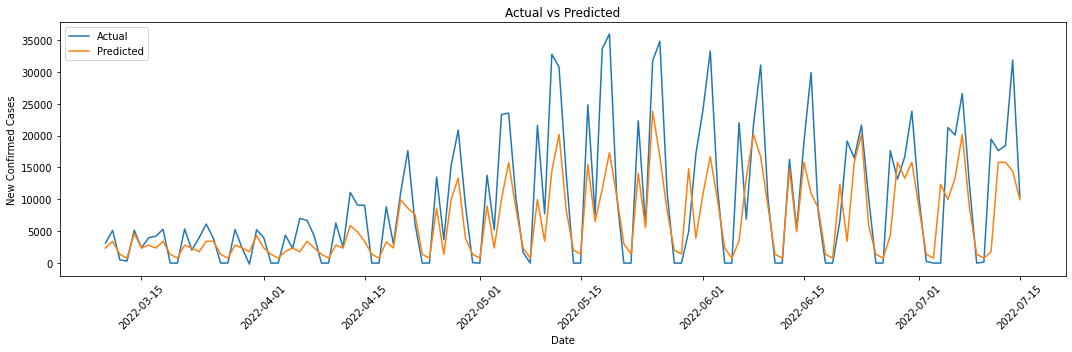

In [11]:
param_grid = {

    'learning_rate': [0.1, 0.2, 0.3, 0.8],

    'max_depth': [2, 3, 8, 9],

    'subsample': [0.2, 0.8, 0.9],

    'n_estimators': [10, 50, 100, 200]

}

xgb_search(Xtrain, Xtest, ytrain, ytest, param_grid)

Feature importances:
current_hospitalized_patients: 0.3157442510128021
7_day_shift: 0.19860683381557465
new_persons_fully_vaccinated_janssen: 0.04660455137491226
current_intensive_care_patients: 0.03388993814587593
cumulative_confirmed: 0.02957266755402088
new_hospitalized_patients: 0.02956465817987919
relative_humidity: 0.02846684865653515
new_vaccine_doses_administered_pfizer: 0.026261955499649048
contact_tracing: 0.02620254084467888
facial_coverings: 0.024945812299847603
2_day_shift: 0.024873986840248108
1_day_shift: 0.0233182180672884
rainfall_mm: 0.020193662494421005
7_day_avg: 0.018030798062682152
new_deceased: 0.017314700409770012
income_support: 0.014330108650028706
new_vaccine_doses_administered: 0.013231591321527958
school_closing: 0.009977666661143303
average_temperature_celsius: 0.009861410595476627
dew_point: 0.009709849953651428
minimum_temperature_celsius: 0.008723927661776543
new_vaccine_doses_administered_moderna: 0.00790134072303772
new_persons_fully_vaccinated_modern

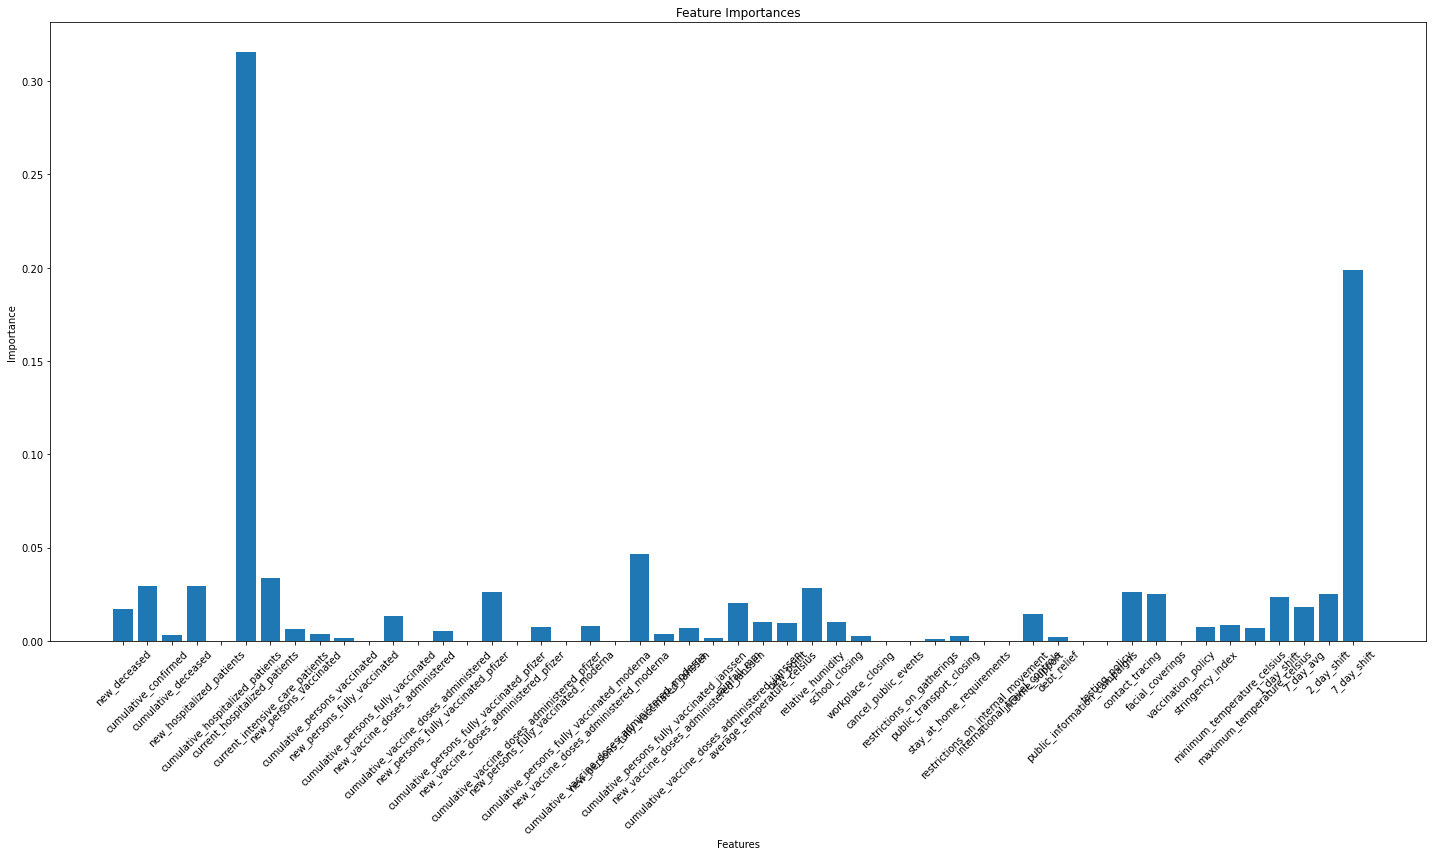

In [58]:
feature_importances = xgb_model.feature_importances_

# Assuming Xtrain is a pandas DataFrame and you want to print feature importance
feature_names = Xtrain.columns
importance_dict = dict(zip(feature_names, feature_importances))

# Print the feature importance
print("Feature importances:")
for feature, importance in sorted(importance_dict.items(), key=lambda item: item[1], reverse=True):
    print(f"{feature}: {importance}")

# If you want to visualize the feature importances
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 12))
plt.bar(range(len(feature_importances)), feature_importances, tick_label=feature_names)
plt.xticks(rotation=45)
plt.title("Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()  # Adjust subplot parameters to give specified padding
plt.show()

In [42]:
xgb_model = XGBRegressor()

xgb_model.fit(Xtrain, ytrain)

predictions = xgb_model.predict(Xtest)

Xtrain

,new_deceased,cumulative_confirmed,cumulative_deceased,new_hospitalized_patients,cumulative_hospitalized_patients,current_hospitalized_patients,current_intensive_care_patients,new_persons_vaccinated,cumulative_persons_vaccinated,new_persons_fully_vaccinated,...,facial_coverings,vaccination_policy,stringency_index,minimum_temperature_celsius,maximum_temperature_celsius,1_day_shift,7_day_avg,2_day_shift,8_day_shift,9_day_shift
124,34.0,661529.0,46776.0,4.0,25634.61,1510.0,362.91,0.0,0.0,0.0,...,3.000000,0.0,67.130000,15.261111,34.716049,1683.0,1628.714286,2020.0,1016.0,1824.0
167,10.0,741419.0,48581.0,145.0,6088.00,1595.0,337.00,0.0,0.0,0.0,...,3.333333,0.0,66.203333,15.655556,29.205556,1317.0,1854.285714,1907.0,1641.0,1927.0
250,28.0,1030452.0,51396.0,722.0,30115.00,5052.0,1057.00,0.0,0.0,0.0,...,3.333333,0.0,59.260000,2.577778,25.098765,11422.0,8448.857143,9365.0,6310.0,7294.0
758,24.0,9960035.0,144820.0,221.0,548841.00,1638.0,238.00,9422.0,36153071.0,8762.0,...,2.000000,5.0,36.726667,3.088889,21.623457,4988.0,4816.428571,3916.0,5334.0,2760.0
693,644.0,9386321.0,133963.0,2144.0,509816.00,19433.0,2886.00,28090.0,35116451.0,18301.0,...,2.000000,5.0,39.816667,-10.105556,6.044444,26841.0,46286.428571,41067.0,51594.0,99975.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,100.0,658452.0,46703.0,73.0,25919.50,1629.0,377.17,0.0,0.0,0.0,...,3.000000,0.0,67.130000,17.561111,34.506173,2175.0,1630.428571,1560.0,1652.0,1272.0
256,100.0,1110961.0,51925.0,1003.0,36017.00,6757.0,1406.00,0.0,0.0,0.0,...,3.333333,0.0,59.720000,-1.361111,12.650000,14955.0,12762.857143,14521.0,9365.0,8473.0
391,141.0,3779017.0,99125.0,1066.0,244064.00,9140.0,1768.00,190867.0,12692670.0,186157.0,...,3.000000,3.0,51.233333,0.211111,18.116667,15933.0,18346.285714,17015.0,9040.0,15317.0
233,63.0,911366.0,50549.0,411.0,21210.00,3048.0,650.00,0.0,0.0,0.0,...,3.333333,0.0,60.496667,8.377778,26.816667,4752.0,4359.857143,3993.0,3649.0,3880.0


# ESC

In [13]:
Xtrain, Xtest, ytrain, ytest = prepare_and_split_data(esc)

/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8

Text(0.5, 0, 'gamma')

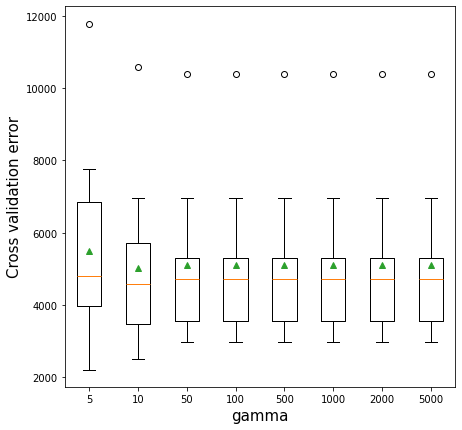

In [14]:
models = n_trees()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, Xtrain, ytrain)
    results.append(scores)
    names.append(name)
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('gamma',fontsize=15)

Text(0.5, 0, 'gamma')

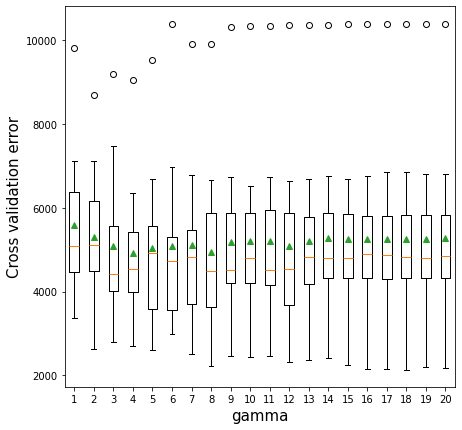

In [15]:
models = max_depth()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, Xtrain, ytrain)
    results.append(scores)
    names.append(name)
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('gamma',fontsize=15)

Text(0.5, 0, 'gamma')

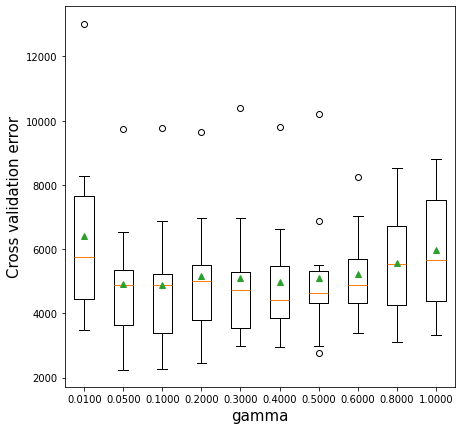

In [16]:
models = learning_rate()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, Xtrain, ytrain)
    results.append(scores)
    names.append(name)
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('gamma',fontsize=15)

Text(0.5, 0, 'gamma')

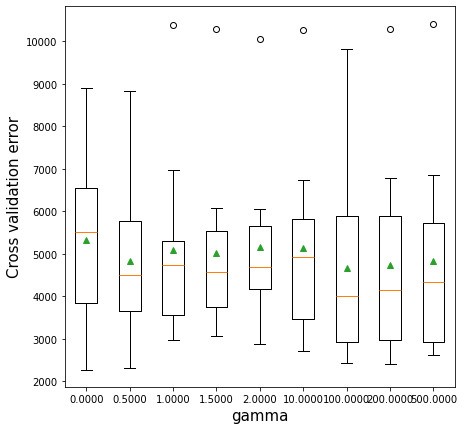

In [17]:
models = reg_lambda()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, Xtrain, ytrain)
    results.append(scores)
    names.append(name)
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('gamma',fontsize=15)

Text(0.5, 0, 'gamma')

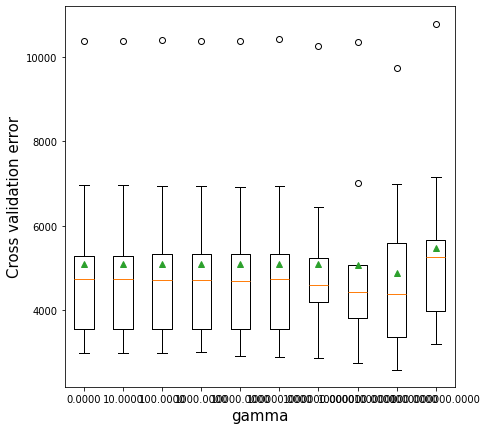

In [18]:
models = gamma()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, Xtrain, ytrain)
    results.append(scores)
    names.append(name)
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('gamma',fontsize=15)

Text(0.5, 0, 'gamma')

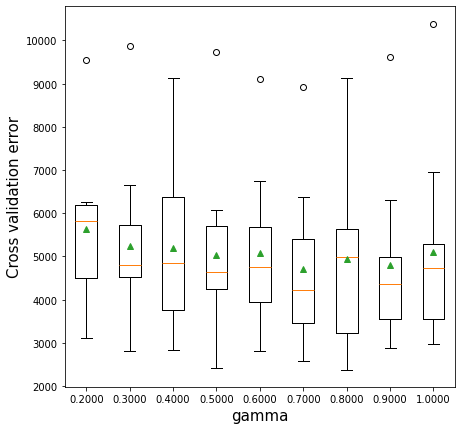

In [19]:
models = subsample()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, Xtrain, ytrain)
    results.append(scores)
    names.append(name)
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('gamma',fontsize=15)

Optimal parameter values = {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 50, 'reg_lambda': 1.5, 'subsample': 0.8}
Optimal cross validation R-squared =  0.5396349152486359
MAE: 1909.1622931957245
RMSE: 3339.3216470071816
MSE: 11151069.062170755
MASE: 0.5215831859571842


<Figure size 1440x864 with 0 Axes>

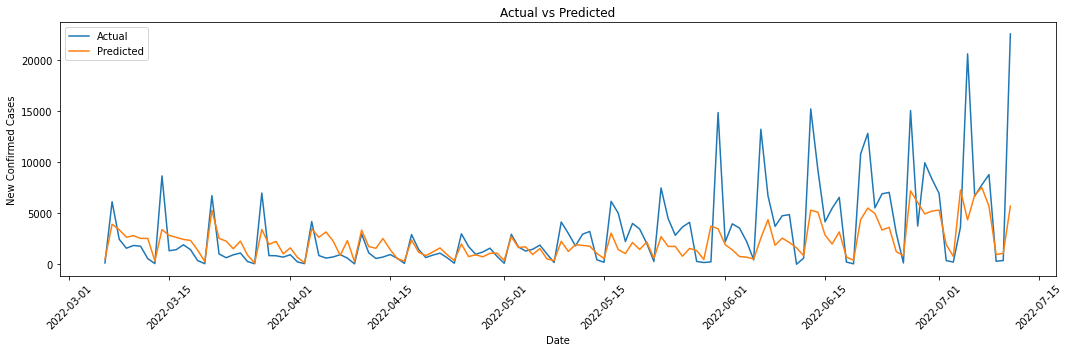

In [21]:
param_grid = {

    'learning_rate': [.05, .1, .2, .5],

    'max_depth': [4, 7, 8, 9],

    'subsample': [.7, .8, .9],

    'n_estimators': [10, 50, 100],

    'reg_lambda': [.5, 1, 1.5]

}

xgb_search(Xtrain, Xtest, ytrain, ytest, param_grid)

# Mid Atlantic

In [23]:
Xtrain, Xtest, ytrain, ytest = prepare_and_split_data(midatl)

/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8

Text(0.5, 0, 'ntrees')

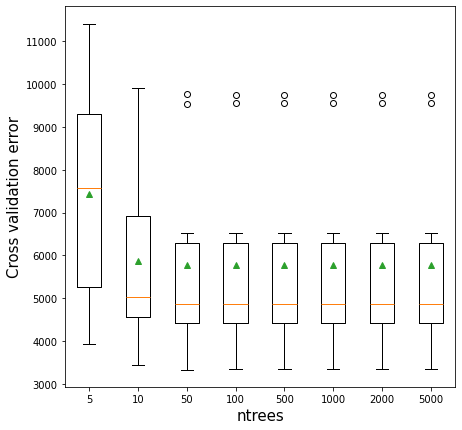

In [24]:
models = n_trees()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, Xtrain, ytrain)
    results.append(scores)
    names.append(name)
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('ntrees',fontsize=15)

Text(0.5, 0, 'maxdepth')

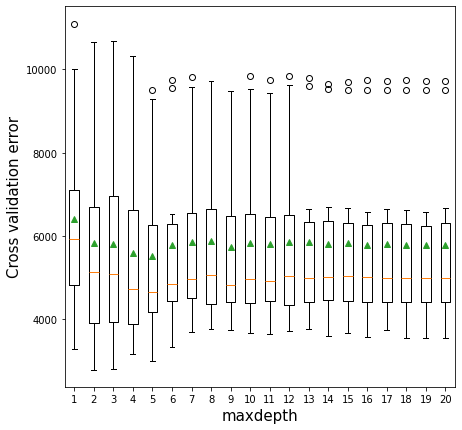

In [25]:
models = max_depth()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, Xtrain, ytrain)
    results.append(scores)
    names.append(name)
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('maxdepth',fontsize=15)

Text(0.5, 0, 'learningrate')

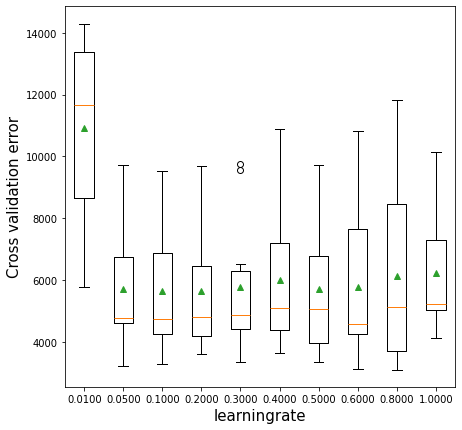

In [26]:
models = learning_rate()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, Xtrain, ytrain)
    results.append(scores)
    names.append(name)
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('learningrate',fontsize=15)

Text(0.5, 0, 'reg lambda')

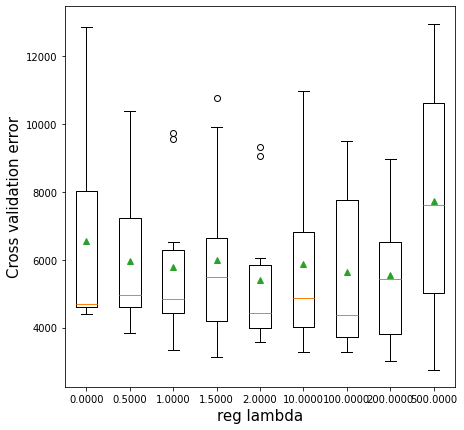

In [27]:
models = reg_lambda()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, Xtrain, ytrain)
    results.append(scores)
    names.append(name)
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('reg lambda',fontsize=15)

Text(0.5, 0, 'gamma')

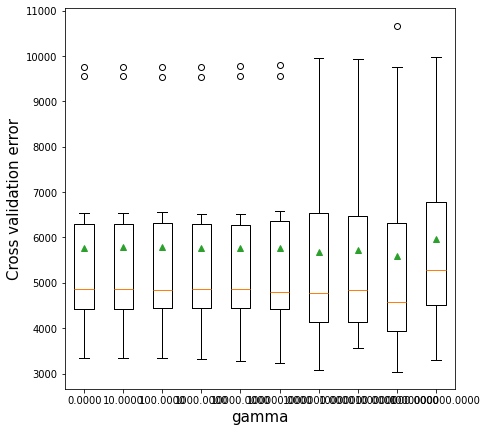

In [28]:
models = gamma()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, Xtrain, ytrain)
    results.append(scores)
    names.append(name)
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('gamma',fontsize=15)

Text(0.5, 0, 'subsample')

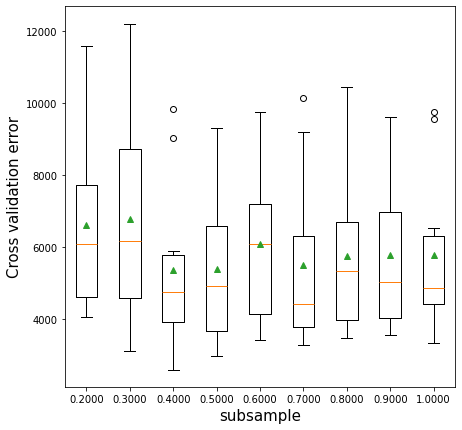

In [29]:
models = subsample()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, Xtrain, ytrain)
    results.append(scores)
    names.append(name)
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('subsample',fontsize=15)

Optimal parameter values = {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100, 'reg_lambda': 2, 'subsample': 0.7}
Optimal cross validation R-squared =  0.589114928003556
MAE: 2958.666771298363
RMSE: 4752.757856050821
MSE: 22588707.238252793
MASE: 1.2792325820414086


<Figure size 1440x864 with 0 Axes>

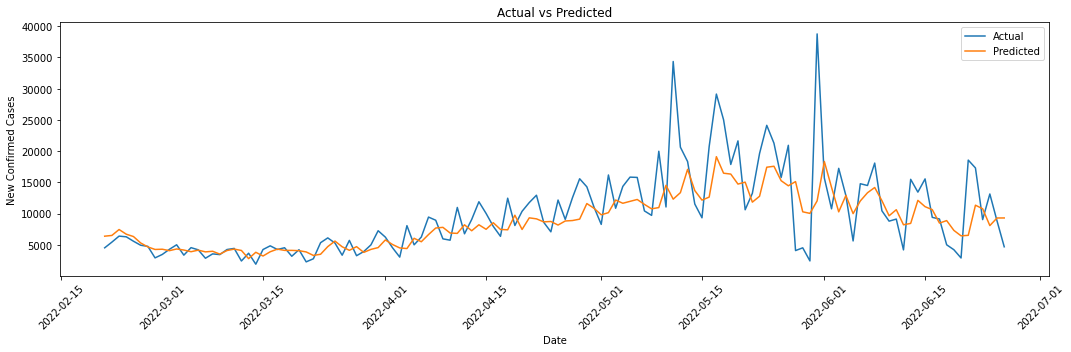

In [31]:
param_grid = {

    'learning_rate': [.05, .3, .5],

    'max_depth': [4, 5, 9],

    'subsample': [.4, .5, .7],

    'n_estimators': [10, 50, 100],

    'reg_lambda': [1, 2, 100]

}

xgb_search(Xtrain, Xtest, ytrain, ytest, param_grid)

# Mountain

In [43]:
Xtrain, Xtest, ytrain, ytest = prepare_and_split_data(mount)

/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8

Text(0.5, 0, 'ntrees')

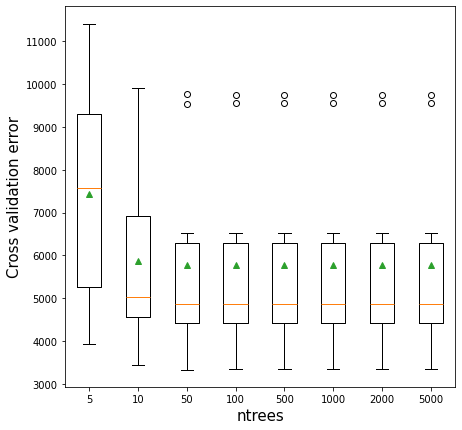

In [37]:
models = n_trees()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, Xtrain, ytrain)
    results.append(scores)
    names.append(name)
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('ntrees',fontsize=15)

Text(0.5, 0, 'ntrees')

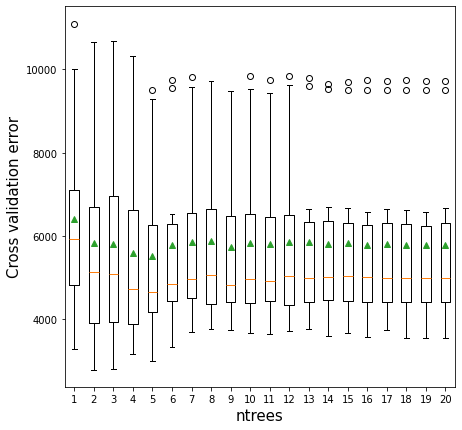

In [38]:
models = max_depth()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, Xtrain, ytrain)
    results.append(scores)
    names.append(name)
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('ntrees',fontsize=15)

Text(0.5, 0, 'ntrees')

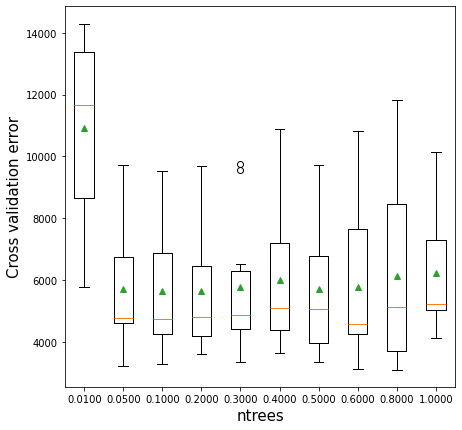

In [39]:
models = learning_rate()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, Xtrain, ytrain)
    results.append(scores)
    names.append(name)
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('ntrees',fontsize=15)

Text(0.5, 0, 'ntrees')

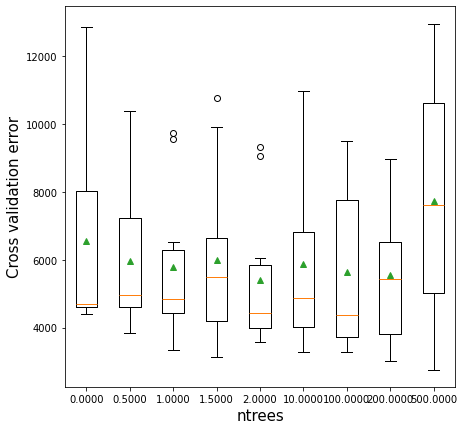

In [40]:
models = reg_lambda()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, Xtrain, ytrain)
    results.append(scores)
    names.append(name)
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('ntrees',fontsize=15)

Text(0.5, 0, 'ntrees')

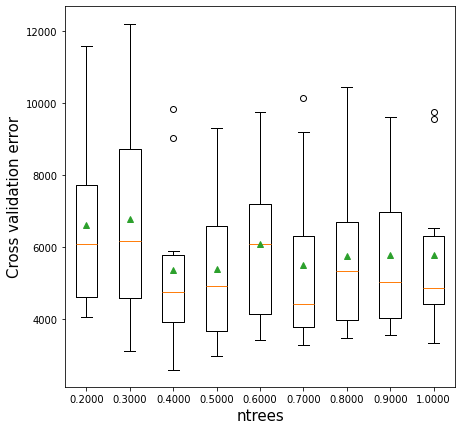

In [41]:
models = subsample()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, Xtrain, ytrain)
    results.append(scores)
    names.append(name)
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('ntrees',fontsize=15)

Optimal parameter values = {'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 100, 'reg_lambda': 1, 'subsample': 0.4}
Optimal cross validation R-squared =  0.5890423251292267
MAE: 2770.530870813084
RMSE: 4571.690340522024
MSE: 20900352.56962238
MASE: 0.8207019411203491


<Figure size 1440x864 with 0 Axes>

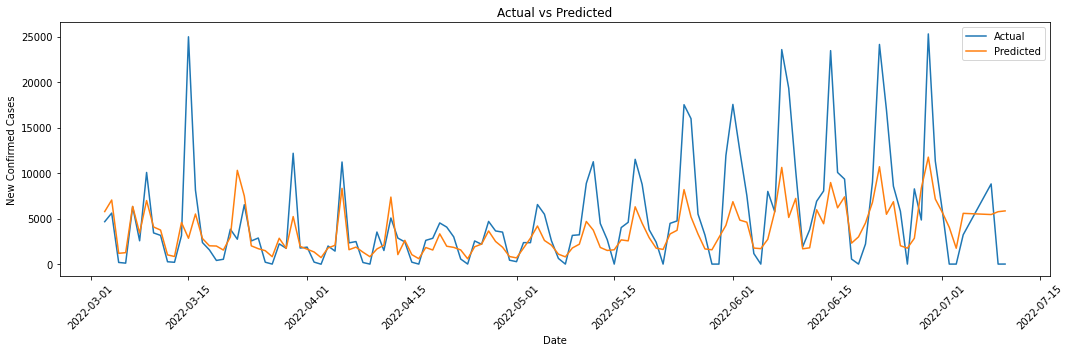

In [44]:
param_grid = {

    'learning_rate': [.05, .2, .5],

    'max_depth': [4, 5, 9],

    'subsample': [.4, .5, .7],

    'n_estimators': [10, 50, 100],

    'reg_lambda': [1, 2]

}

xgb_search(Xtrain, Xtest, ytrain, ytest, param_grid)

# New England

In [46]:
Xtrain, Xtest, ytrain, ytest = prepare_and_split_data(ne)

Optimal parameter values = {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50, 'reg_lambda': 1, 'subsample': 0.4}
Optimal cross validation R-squared =  0.5350441380787498
MAE: 1686.128413995107
RMSE: 2650.5523290404503
MSE: 7025427.648981755
MASE: 0.6704385934285513


<Figure size 1440x864 with 0 Axes>

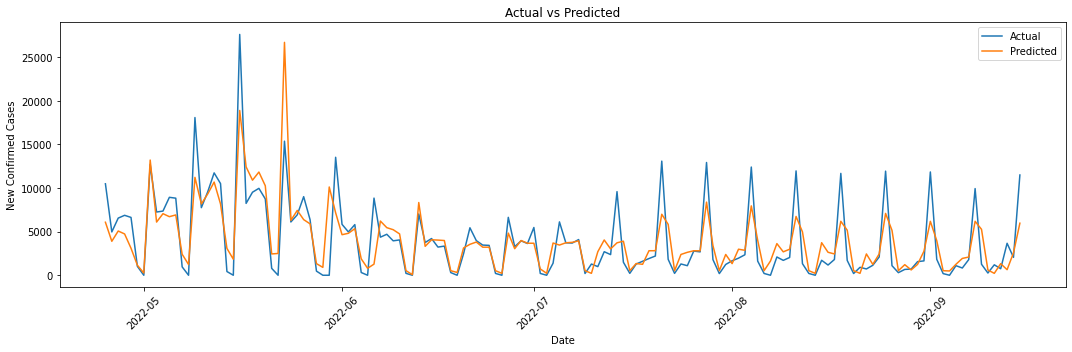

In [47]:
param_grid = {

    'learning_rate': [.05, .2, .5],

    'max_depth': [4, 5, 9],

    'subsample': [.4, .5, .7],

    'n_estimators': [10, 50, 100],

    'reg_lambda': [1, 2]

}

xgb_search(Xtrain, Xtest, ytrain, ytest, param_grid)

# Pacific

In [48]:
Xtrain, Xtest, ytrain, ytest = prepare_and_split_data(pac)

Optimal parameter values = {'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 50, 'reg_lambda': 2, 'subsample': 0.4}
Optimal cross validation R-squared =  0.6282930781775846
MAE: 11300.313354492188
RMSE: 16410.70534545138
MSE: 269311249.93522656
MASE: 1.6685078769611308


<Figure size 1440x864 with 0 Axes>

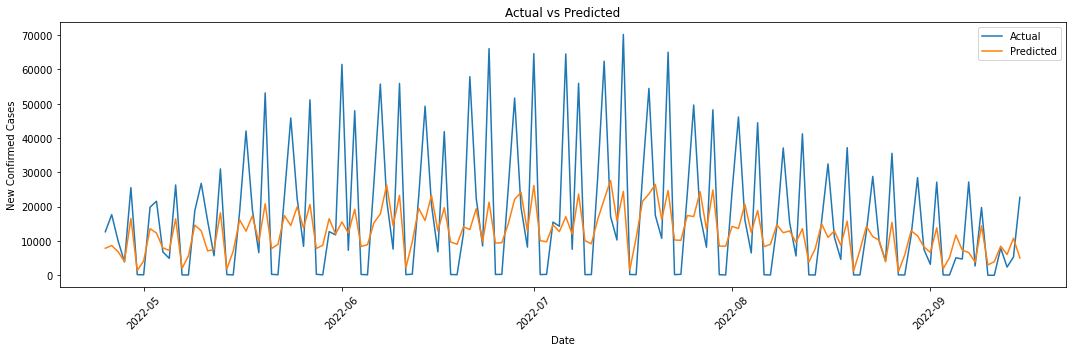

In [49]:
param_grid = {

    'learning_rate': [.05, .2, .5],

    'max_depth': [4, 5, 9],

    'subsample': [.4, .5, .7],

    'n_estimators': [10, 50, 100],

    'reg_lambda': [1, 2]

}

xgb_search(Xtrain, Xtest, ytrain, ytest, param_grid)

# South Atlantic

In [50]:
Xtrain, Xtest, ytrain, ytest = prepare_and_split_data(satl)

Optimal parameter values = {'learning_rate': 0.5, 'max_depth': 9, 'n_estimators': 10, 'reg_lambda': 1, 'subsample': 0.7}
Optimal cross validation R-squared =  0.6501718037154925
MAE: 12594.34728998608
RMSE: 18423.06910958641
MSE: 339409475.41659695
MASE: 1.199729373388254


<Figure size 1440x864 with 0 Axes>

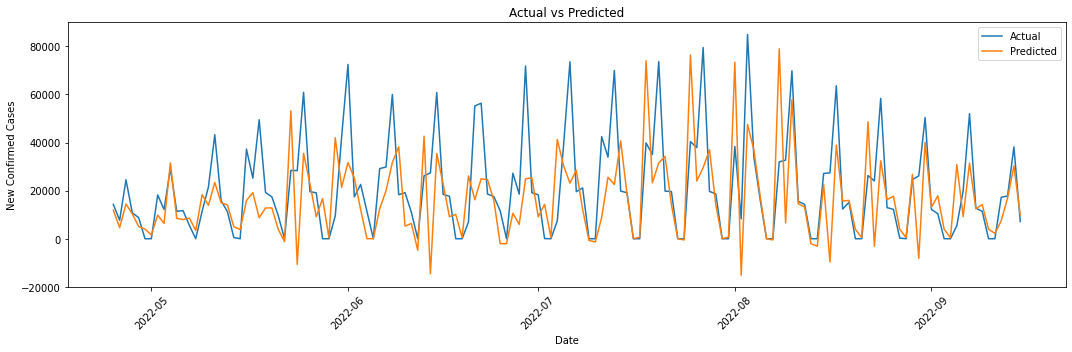

In [51]:
param_grid = {

    'learning_rate': [.05, .2, .5],

    'max_depth': [4, 5, 9],

    'subsample': [.4, .5, .7],

    'n_estimators': [10, 50, 100],

    'reg_lambda': [1, 2]

}

xgb_search(Xtrain, Xtest, ytrain, ytest, param_grid)

# WNC

In [54]:
Xtrain, Xtest, ytrain, ytest = prepare_and_split_data(wnc)

Optimal parameter values = {'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 50, 'reg_lambda': 2, 'subsample': 0.4}
Optimal cross validation R-squared =  0.5743517750213621
MAE: 2506.8579081429375
RMSE: 3111.0406179978686
MSE: 9678573.72683256
MASE: 0.7952870725341765


<Figure size 1440x864 with 0 Axes>

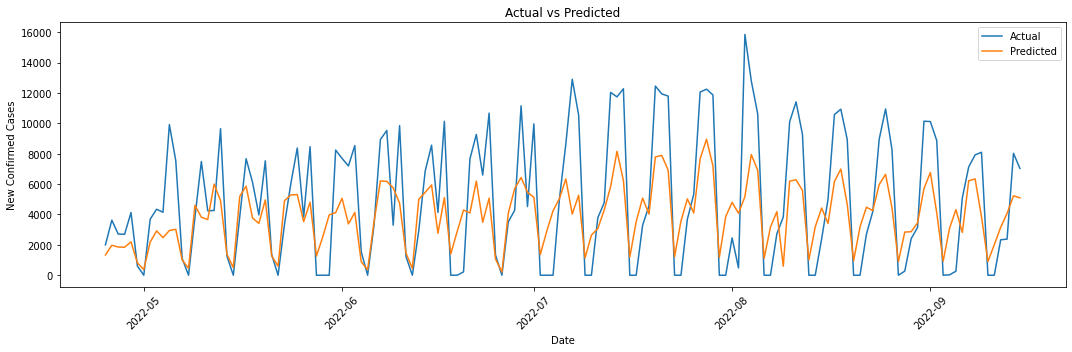

In [55]:
param_grid = {

    'learning_rate': [.05, .2, .5],

    'max_depth': [4, 5, 9],

    'subsample': [.4, .5, .7],

    'n_estimators': [10, 50, 100],

    'reg_lambda': [1, 2]

}

xgb_search(Xtrain, Xtest, ytrain, ytest, param_grid)

# WSC

In [56]:
Xtrain, Xtest, ytrain, ytest = prepare_and_split_data(wsc)

Optimal parameter values = {'learning_rate': 0.5, 'max_depth': 4, 'n_estimators': 10, 'reg_lambda': 2, 'subsample': 0.7}
Optimal cross validation R-squared =  0.5989143782530687
MAE: 4210.7534908718535
RMSE: 6435.637014906012
MSE: 41417423.78762837
MASE: 0.9460014896470261


<Figure size 1440x864 with 0 Axes>

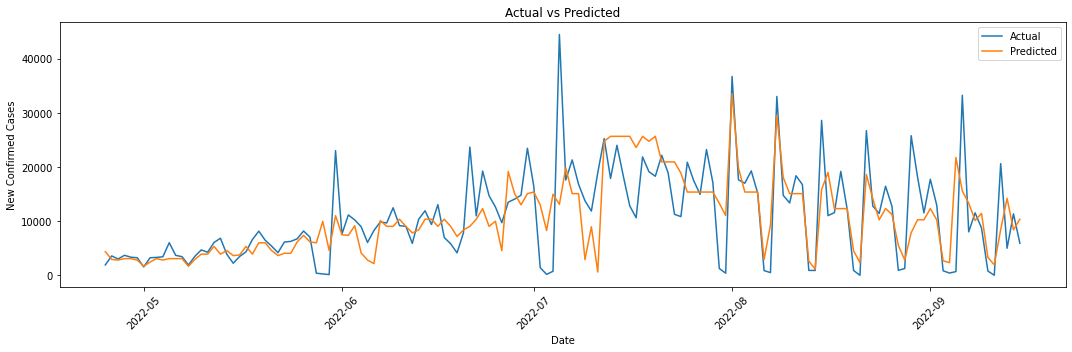

In [57]:
param_grid = {

    'learning_rate': [.05, .2, .5],

    'max_depth': [4, 5, 9],

    'subsample': [.4, .5, .7],

    'n_estimators': [10, 50, 100],

    'reg_lambda': [1, 2]

}

xgb_search(Xtrain, Xtest, ytrain, ytest, param_grid)